<img src="img/Logo_FGV.png"  width="10%" align="left"/>

# MBA Business Intelligence & Big Data
***

## Faria Lima T3 - Aplicações em Geoanalise
<br>
**Integrantes Grupo:**
<br>Danillo Silva
<br>Diego Dantas
<br>Gustavo Sainatto
<br>Nestor Soken
<br>Rubia Quinteiro Nierotka
***

In [1]:
#Libraries:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.externals import joblib

import warnings

%matplotlib inline
warnings.simplefilter('ignore')

C:\Users\silvada010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Import Dataset for Exploratory Analysis:
***

In [2]:
#Import Base Dataset:

df_base = pd.read_excel('datasets/00_Dataset_base.xls', sheet_name='Dataset_Base')

df_base.info()
df_base.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 16 columns):
NOME DA BARRAGEM DE MINERAÇÃO    769 non-null object
NOME DO EMPREENDEDOR             769 non-null object
CPF/CNPJ                         769 non-null object
LATITUDE                         769 non-null object
LONGITUDE                        769 non-null object
POSICIONAMENTO                   769 non-null object
UF                               769 non-null object
MUNICÍPIO                        769 non-null object
MINÉRIO PRINCIPAL                769 non-null object
ALTURA ATUAL (m)                 769 non-null float64
VOLUME ATUAL (m3)                769 non-null float64
MÉTODO CONSTRUTIVO               769 non-null object
CATEGORIA DE RISCO               425 non-null object
DANO POTENCIAL ASSOCIADO         425 non-null object
CLASSE                           425 non-null object
INSERIDA NA PNSB?                769 non-null object
dtypes: float64(2), object(14)
memory usage: 

,NOME DA BARRAGEM DE MINERAÇÃO,NOME DO EMPREENDEDOR,CPF/CNPJ,LATITUDE,LONGITUDE,POSICIONAMENTO,UF,MUNICÍPIO,MINÉRIO PRINCIPAL,ALTURA ATUAL (m),VOLUME ATUAL (m3),MÉTODO CONSTRUTIVO,CATEGORIA DE RISCO,DANO POTENCIAL ASSOCIADO,CLASSE,INSERIDA NA PNSB?
0,0-1,Mineração Taboca S.a.,34.019.992/0001-10,"-0°44'00.100""","-60°08'18.200""",Sul do Equador,AM,PRESIDENTE FIGUEIREDO,Minério de Estanho Primário,22.0,27700000.0,Etapa única,Baixa,Média,C,Sim
1,103 (Cruz),Mineração Taboca S.a.,34.019.992/0001-10,"-0°47'08.600""","-60°08'30.900""",Sul do Equador,AM,PRESIDENTE FIGUEIREDO,Minério de Estanho Primário,10.3,924000.0,Etapa única,Baixa,Média,C,Sim
2,111 (Índio),Mineração Taboca S.a.,34.019.992/0001-10,"-0°47'22.800""","-60°08'39.400""",Sul do Equador,AM,PRESIDENTE FIGUEIREDO,Minério de Estanho Primário,5.0,48873.0,Etapa única,Baixa,Média,C,Sim
3,158 (A-1),Mineração Taboca S.a.,34.019.992/0001-10,"-0°44'16.900""","-60°04'44.100""",Sul do Equador,AM,PRESIDENTE FIGUEIREDO,Minério de Estanho Primário,30.0,53380000.0,Alteamento a jusante,Baixa,Alta,B,Sim
4,161 (A-2),Mineração Taboca S.a.,34.019.992/0001-10,"-0°43'56.233""","-60°04'08.396""",Sul do Equador,AM,PRESIDENTE FIGUEIREDO,Minério de Estanho Primário,22.0,1018054.0,Etapa única,Baixa,Média,C,Sim


### Data Inspection - All Features + TARGET:
***

#### Feature: Nome do Empreendedor
***

Nº de Empreendedores Únicos: 249


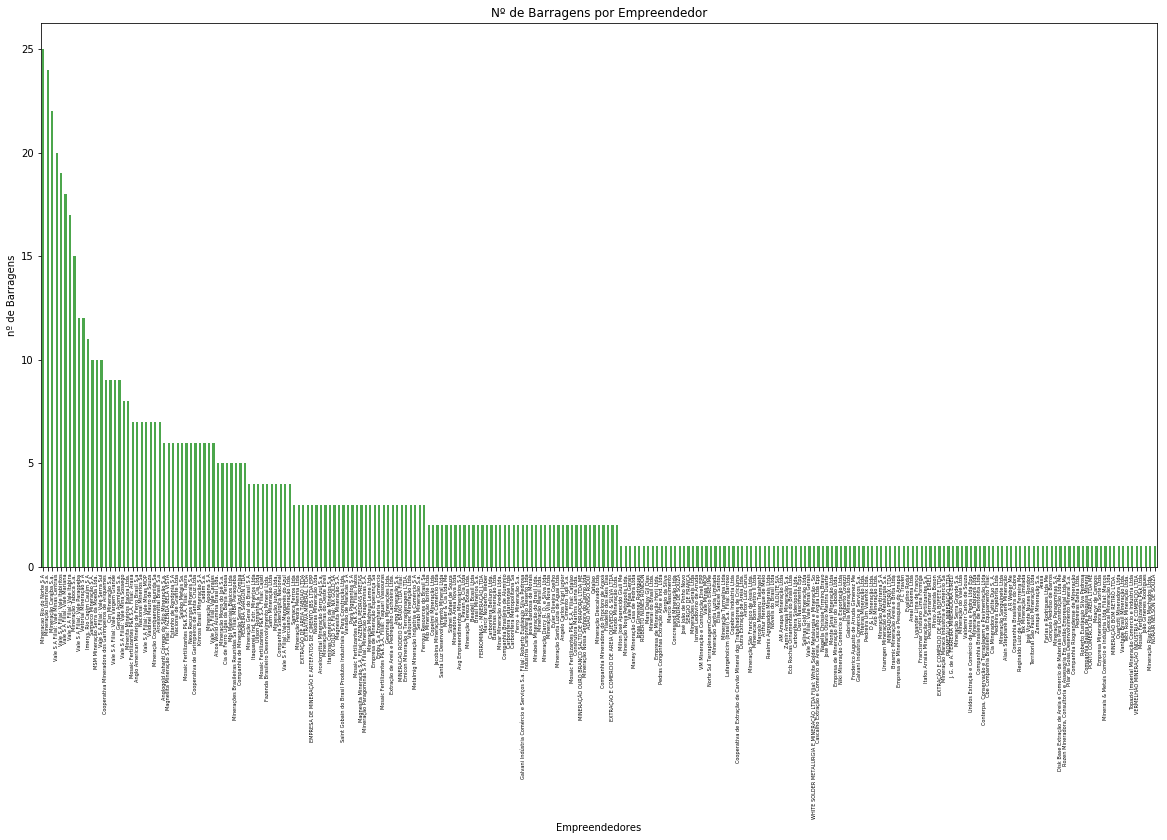

In [3]:
#Main Figures from Feature:

print('Nº de Empreendedores Únicos: {}'.format(df_base['NOME DO EMPREENDEDOR'].nunique()))


ax = df_base['NOME DO EMPREENDEDOR'].value_counts().plot(kind='bar', color='green', alpha=0.7, figsize=(20,10))

_= ax.set_title('Nº de Barragens por Empreendedor')
_= ax.set_xlabel('Empreendedores')
_= ax.set_ylabel('nº de Barragens')

_= ax.set_xticklabels(df_base['NOME DO EMPREENDEDOR'].value_counts().index, rotation=90, size=5)

del ax

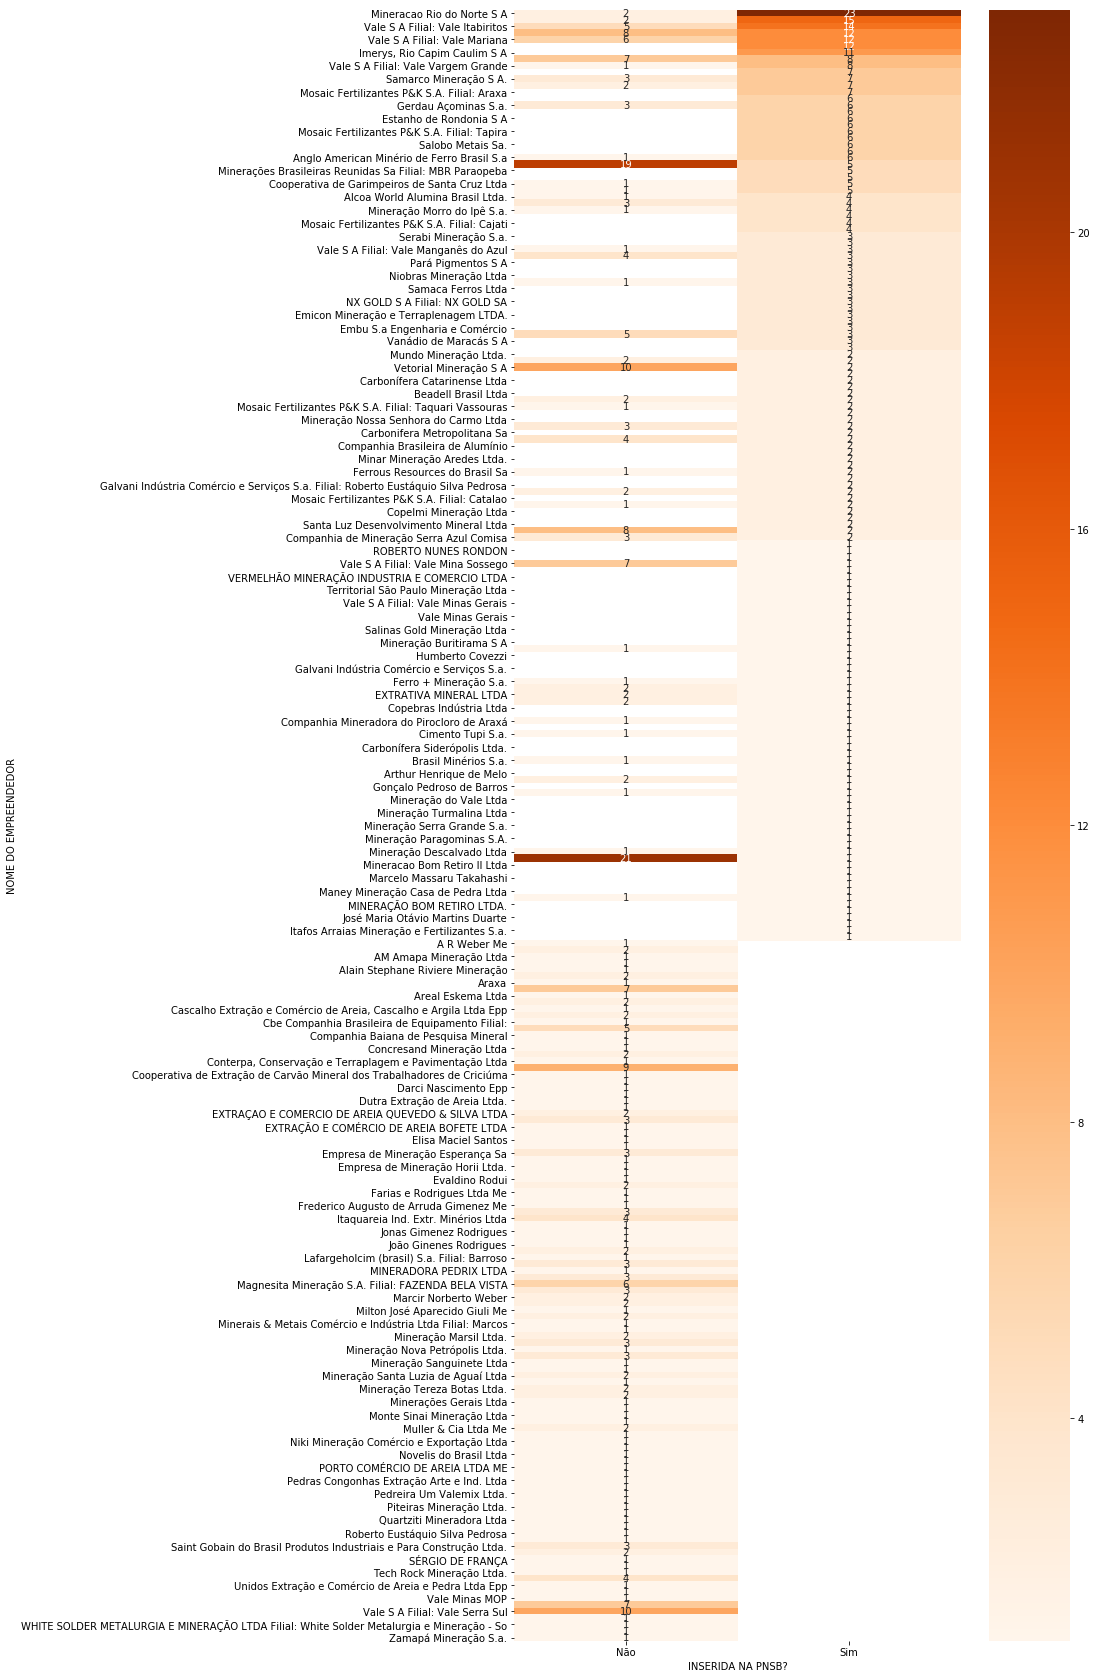

In [4]:
#Crosstab Classified vs. Non-Classified:

fig = plt.figure(figsize=(10,30))

_= sns.heatmap(pd.crosstab(columns=df_base['INSERIDA NA PNSB?'],index=df_base['NOME DO EMPREENDEDOR'],
                           values=df_base['NOME DO EMPREENDEDOR'],aggfunc='count').sort_values(by='Sim',ascending=False),
               cmap='Oranges', annot=True)

del fig

**Observção:**
<br>Não iremos utilizar essa variavel no Estudo, pois não existe balanceamento entre os Dados Classificados vs. Não Classificados.
<br>Uma possibilidade para Balanceamento da Variável seria realizar o tratamento da mesma via Text Mining, procurando encontrar padrões entre os diversos cadastros sociais das empresas `(e.g. Vale S.A Filial vs. Vale)`


#### Feature: Latitude / Longitude
***

In [5]:
#Parse Latitude Data into numerical Categories:

#Define Split Coords Function:
def split_coord(coord_list):
    grau = []
    minuto = []
    segundo = []
    
    coord = coord_list
    
    for i in range(len(coord_list)):
        grau.append(coord[i].split("°")[0])
        minuto.append(coord[i].split("°")[1].split("'")[0])
        segundo.append(coord[i].split("°")[1].split("'")[1].split('"')[0])
    
    return [grau,minuto,segundo]

In [6]:
#Feature Creation - LATITUDE_GRAU, LATITUDE_MINUTO, LATITUDE_SEGUNDO:

lat = split_coord(df_base['LATITUDE'].astype(str).tolist())

df_base['LATITUDE_GRAU'] = pd.to_numeric(lat[0], errors='coerce')
df_base['LATITUDE_MINUTO'] = pd.to_numeric(lat[1], errors='coerce')
df_base['LATITUDE_SEGUNDO'] = pd.to_numeric(lat[2], errors='coerce')

df_base['LATITUDE_GRAU'].fillna(0, inplace=True)
df_base['LATITUDE_MINUTO'].fillna(0, inplace=True)
df_base['LATITUDE_SEGUNDO'].fillna(0, inplace=True)

del lat

In [7]:
#Feature Creation - LONGITUDE_GRAU, LONGITUDE_MINUTO, LONGITUDE_SEGUNDO:

long = split_coord(df_base['LONGITUDE'].astype(str).tolist())

df_base['LONGITUDE_GRAU'] = pd.to_numeric(long[0], errors='coerce')
df_base['LONGITUDE_MINUTO'] = pd.to_numeric(long[1], errors='coerce')
df_base['LONGITUDE_SEGUNDO'] = pd.to_numeric(long[2], errors='coerce')

df_base['LONGITUDE_GRAU'].fillna(0, inplace=True)
df_base['LONGITUDE_MINUTO'].fillna(0, inplace=True)
df_base['LONGITUDE_SEGUNDO'].fillna(0, inplace=True)

del long

In [8]:
#Show a Sample from New Features - LATITUDE:

df_base[['LATITUDE','LATITUDE_GRAU','LATITUDE_MINUTO','LATITUDE_SEGUNDO']].sample(5)

,LATITUDE,LATITUDE_GRAU,LATITUDE_MINUTO,LATITUDE_SEGUNDO
665,"-6°26'36.800""",-6.0,26,36.800
260,"-19°10'31.131""",-19.0,10,31.131
532,"-19°56'18.423""",-19.0,56,18.423
560,"-21°18'31.440""",-21.0,18,31.440
180,"-18°55'14.984""",-18.0,55,14.984


In [9]:
#Show a Sample from New Features - LONGITUDE:

df_base[['LONGITUDE','LONGITUDE_GRAU','LONGITUDE_MINUTO','LONGITUDE_SEGUNDO']].sample(5)

,LONGITUDE,LONGITUDE_GRAU,LONGITUDE_MINUTO,LONGITUDE_SEGUNDO
415,"-46°08'07.200""",-46,8,7.200
375,"-63°31'12.111""",-63,31,12.111
125,"-46°54'07.890""",-46,54,7.890
421,"-47°37'05.800""",-47,37,5.800
116,"-44°28'24.200""",-44,28,24.200


#### Feature: POSICIONAMENTO
***

In [10]:
#Create Categorical Feature:

df_base = pd.concat([df_base, pd.get_dummies(df_base['POSICIONAMENTO'])], axis=1)

In [11]:
#Show a Sample of Categorical:

df_base[['POSICIONAMENTO','Norte do Equador','Sul do Equador']].sample(5)

,POSICIONAMENTO,Norte do Equador,Sul do Equador
511,Sul do Equador,0,1
711,Sul do Equador,0,1
167,Sul do Equador,0,1
242,Sul do Equador,0,1
296,Sul do Equador,0,1


#### Feature: UF
***

In [12]:
#Create a Function to Classify States into Regions:

def states_into_regions(states):
    
    if (states == 'AM') | (states == 'RR') | (states == 'AP') | (states == 'PA') | (states == 'TO') | (states == 'RO') | (states == 'AC'):
        return 'NORTE'
    elif (states == 'MA') | (states == 'PI') | (states == 'CE') | (states == 'RN') | (states == 'PE') | (states == 'PB') | (states == 'SE') | (states == 'AL') |(states == 'BA'):
        return 'NORDESTE'
    elif (states == 'MT') | (states == 'MS') | (states == 'GO'):
        return 'CENTRO-OESTE'
    elif (states == 'SP') | (states == 'RJ') | (states == 'ES') | (states == 'MG'):
        return 'SUDESTE'
    elif (states == 'PR') | (states == 'SC') | (states == 'RS'):
        return 'SUL'
    else:
        return np.nan


In [13]:
#Create Categorical Region Feature:

df_base = pd.concat([df_base, pd.get_dummies(df_base['UF'].apply(lambda x: states_into_regions(x)))],axis=1)

In [14]:
#Show Sample of Categorical Feature:

df_base[['UF','NORTE','NORDESTE','CENTRO-OESTE','SUDESTE','SUL']].sample(5)

,UF,NORTE,NORDESTE,CENTRO-OESTE,SUDESTE,SUL
486,MG,0,0,0,1,0
667,PA,1,0,0,0,0
523,MG,0,0,0,1,0
408,SP,0,0,0,1,0
115,MG,0,0,0,1,0


**Observção:**
<br>Optamos por utilizar a Variável Região ao invés de Estados e Municípios por 2 Motivos:
<br>
<br>**1.** Variáveis não eram balanceadas entre Dados Classificados vs. Não Classificados.
<br>
<br>**2.** Ambas as Variáveis já são representadas através de suas Coordenadas Geográficas (LATITUDE E LONGITUDE), onde temos a representação das mesmas em critérios quantitativos.

#### Feature: Minerio Principal
***

In [15]:
#Check Balancing across Base:

df_pivot = df_base.pivot_table(index='MINÉRIO PRINCIPAL', columns='INSERIDA NA PNSB?', values='LATITUDE', aggfunc='count')

df_pivot = df_pivot[df_pivot['Sim'].isna() == True]

print(df_pivot)
print('\nNumero de Barragens com Minério Principal não Mapeados até o momento: {}'.format(df_pivot['Não'].sum()))
print('Percentual sobre total de Barragens: {}%'.format(round(df_pivot['Não'].sum()/df_base.shape[0] *100,2)))

INSERIDA NA PNSB?              Não  Sim
MINÉRIO PRINCIPAL                      
Agalmatolito                   3.0  NaN
Areia Quartzosa                2.0  NaN
Argila Refratária              4.0  NaN
Bentonita                      1.0  NaN
Cromita                        8.0  NaN
Granulito Gnaisse              1.0  NaN
Magnesita                      1.0  NaN
Minério de Cromo               1.0  NaN
Minério de Estanho Secundário  1.0  NaN
Minério de Ouro Secundário     1.0  NaN
Quartzito                      1.0  NaN
Rocha Diamantífera             1.0  NaN
Saibro                         2.0  NaN
Sais                           1.0  NaN
Serpentinito                   1.0  NaN

Numero de Barragens com Minério Principal não Mapeados até o momento: 29.0
Percentual sobre total de Barragens: 3.77%


**Observação:** Pelo fato do Tipo de Minério representar um fator importante no estudo e estar associado ao Risco a Classe de Risco de uma Barragem (devido as características geológicas do local), não iremos manter as 29 Barragens evidenciadas acima no estudo.
<br>Não existem dados comparativos as mesmas dentro da base histórica levantada que nos permita realizar associações confiáveis.

In [16]:
#Remove records from Base Dataset:

go_out = df_pivot.index.tolist()

for i in range(len(go_out)):
    df_base = df_base[df_base['MINÉRIO PRINCIPAL'] != go_out[i]]

del go_out, df_pivot, i

In [17]:
#Create Categorical Region Feature:

df_base = pd.concat([df_base, pd.get_dummies(df_base['MINÉRIO PRINCIPAL'])],axis=1)

#### Feature: Método Construtivo
***

In [18]:
#Create Categorical Feature:

df_base = pd.concat([df_base, pd.get_dummies(df_base['MÉTODO CONSTRUTIVO'])], axis=1)

In [19]:
#Show Sample of Categorical Feature:

df_base[['MÉTODO CONSTRUTIVO','Alteamento a jusante','Alteamento a montante ou desconhecido',
         'Alteamento por linha de centro','Etapa única','Indefinido']].sample(5)

,MÉTODO CONSTRUTIVO,Alteamento a jusante,Alteamento a montante ou desconhecido,Alteamento por linha de centro,Etapa única,Indefinido
649,Indefinido,0,0,0,0,1
186,Etapa única,0,0,0,1,0
662,Alteamento a montante ou desconhecido,0,1,0,0,0
196,Alteamento a montante ou desconhecido,0,1,0,0,0
551,Etapa única,0,0,0,1,0


#### TARGET: CLASSE
***

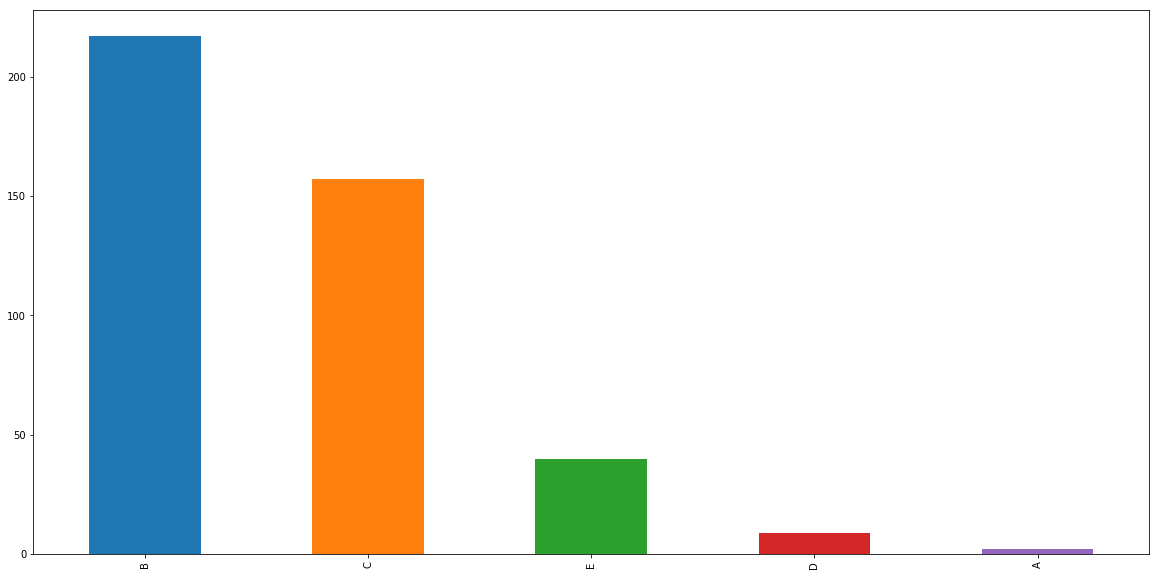

In [20]:
#Plot Feature Characteristics:

df_base['CLASSE'].value_counts().plot(kind='bar', figsize=(20,10))

**Observação:**
<br>Dentro dos Dados Para Barragens Classificadas é possível verificar que as Barragens do tipo crítico `A` podem ser interpretadas como eventos Raros. Dessa forma, se torna complexo realizar um modelo de classificação com foco somente nessa categoria.
<br>É possível aplicarmos técnicas de Resampling para normalizarmos todas as Categorias do Evento Target, porém no nosso estudo estaremos agrupando as categorias `A` e `B` dentro do mesmo grupo de foco (Alto Risco) versus `C`, `D` e `E` (Baixo Risco).
<br>O Motivo para a escolha acima é tentar ao máximo manter a unicidade dos registros coletados, sem gerarmos dados artificiais (dummy records) que seriam necessários dentro de qualquer método de Resampling.

In [21]:
#Create TARGET:

df_base['TARGET'] = [1 if (x == 'A') | (x =='B') else 0 for x in df_base['CLASSE']]

### Organize Dataset for Modeling:
***

#### Columns Labeling:
***

In [22]:
#Adjust Columns Names:

df_base.columns = [x.upper().replace(' ','_').replace('/','_') for x in df_base.columns.tolist()]
print(df_base.columns)

Index(['NOME_DA_BARRAGEM_DE_MINERAÇÃO', 'NOME_DO_EMPREENDEDOR', 'CPF_CNPJ',
       'LATITUDE', 'LONGITUDE', 'POSICIONAMENTO', 'UF', 'MUNICÍPIO',
       'MINÉRIO_PRINCIPAL', 'ALTURA_ATUAL_(M)', 'VOLUME_ATUAL_(M3)',
       'MÉTODO_CONSTRUTIVO', 'CATEGORIA_DE_RISCO', 'DANO_POTENCIAL_ASSOCIADO',
       'CLASSE', 'INSERIDA_NA_PNSB?', 'LATITUDE_GRAU', 'LATITUDE_MINUTO',
       'LATITUDE_SEGUNDO', 'LONGITUDE_GRAU', 'LONGITUDE_MINUTO',
       'LONGITUDE_SEGUNDO', 'NORTE_DO_EQUADOR', 'SUL_DO_EQUADOR',
       'CENTRO-OESTE', 'NORDESTE', 'NORTE', 'SUDESTE', 'SUL',
       'ALUVIÃO_AURÍFERO', 'ALUVIÃO_ESTANÍFERO', 'ALUVIÃO_COM_GEMAS', 'AREIA',
       'AREIA_INDUSTRIAL', 'AREIA_E_CASCALHO', 'ARENITO', 'ARGILA',
       'ARGILA_ARENOSA', 'ARGILA_CAULINÍTICA', 'BAUXITA_GRAU_METALÚRGICO',
       'BAUXITA_GRAU_NÃO_METALÚRGICO', 'CALCÁRIO', 'CALCÁRIO_DOLOMÍTICO',
       'CARVÃO_MINERAL', 'CARVÃO_MINERAL_CAMADA_BARRO_BRANCO',
       'CARVÃO_MINERAL_CAMADA_BONITO', 'CASCALHO', 'CAULIM', 'DOLOMITO',
       '

#### Dataset Split: Features/TARGET + Model/Predict
***

In [23]:
#Split columns for Modeling/Predict:

variables = ['LATITUDE_GRAU',
             'LATITUDE_MINUTO',
             'LATITUDE_SEGUNDO',
             'LONGITUDE_GRAU',
             'LONGITUDE_MINUTO',
             'LONGITUDE_SEGUNDO',
             'NORTE_DO_EQUADOR',
             'SUL_DO_EQUADOR',
             'CENTRO-OESTE',
             'NORDESTE',
             'NORTE',
             'SUDESTE',
             'SUL',
             'ALUVIÃO_AURÍFERO', 'ALUVIÃO_ESTANÍFERO', 'ALUVIÃO_COM_GEMAS', 'AREIA',
             'AREIA_INDUSTRIAL', 'AREIA_E_CASCALHO', 'ARENITO', 'ARGILA',
             'ARGILA_ARENOSA', 'ARGILA_CAULINÍTICA', 'BAUXITA_GRAU_METALÚRGICO',
             'BAUXITA_GRAU_NÃO_METALÚRGICO', 'CALCÁRIO', 'CALCÁRIO_DOLOMÍTICO',
             'CARVÃO_MINERAL', 'CARVÃO_MINERAL_CAMADA_BARRO_BRANCO',
             'CARVÃO_MINERAL_CAMADA_BONITO', 'CASCALHO', 'CAULIM', 'DOLOMITO',
             'FILITO', 'FLUORITA', 'FOSFATO', 'GRANITO', 'HEMATITA', 'ITABIRITO',
             'MINÉRIO_COM_GEMAS', 'MINÉRIO_DE_COBRE', 'MINÉRIO_DE_ESTANHO_PRIMÁRIO',
             'MINÉRIO_DE_FERRO', 'MINÉRIO_DE_MANGANÊS', 'MINÉRIO_DE_NIÓBIO',
             'MINÉRIO_DE_NÍQUEL', 'MINÉRIO_DE_OURO_PRIMÁRIO', 'MINÉRIO_DE_VANÁDIO',
             'MINÉRIO_DE_ZINCO', 'PEGMATITO', 'ROCHA_AURÍFERA', 'ROCHA_CARBONÁTICA',
             'ROCHA_FOSFÁTICA', 'SEDIMENTO', 'SILVANITA', 'VERMICULITA', 'XISTO',
             'ALTURA_ATUAL_(M)',
             'VOLUME_ATUAL_(M3)',
             'ALTEAMENTO_A_JUSANTE',
             'ALTEAMENTO_A_MONTANTE_OU_DESCONHECIDO',
             'ALTEAMENTO_POR_LINHA_DE_CENTRO',
             'ETAPA_ÚNICA',
             'INDEFINIDO',
             'TARGET',
             'INSERIDA_NA_PNSB?']

df_base= df_base[variables]

del variables

In [24]:
#Split Records across Model and Predict Datasets:

df_base[df_base['INSERIDA_NA_PNSB?']=='Sim'].drop('INSERIDA_NA_PNSB?',axis=1).to_parquet('model_dataset.parquet')

df_base[df_base['INSERIDA_NA_PNSB?']=='Não'].drop('INSERIDA_NA_PNSB?',axis=1).to_parquet('predict_dataset.parquet')

del df_base

### Predictive Modeling - Model Dataset:
***

#### Load Model Dataset:
***

In [25]:
#Load .parquet file:

df_model = pd.read_parquet('model_dataset.parquet')

In [26]:
df_model.sample(5)

,LATITUDE_GRAU,LATITUDE_MINUTO,LATITUDE_SEGUNDO,LONGITUDE_GRAU,LONGITUDE_MINUTO,LONGITUDE_SEGUNDO,NORTE_DO_EQUADOR,SUL_DO_EQUADOR,CENTRO-OESTE,NORDESTE,...,VERMICULITA,XISTO,ALTURA_ATUAL_(M),VOLUME_ATUAL_(M3),ALTEAMENTO_A_JUSANTE,ALTEAMENTO_A_MONTANTE_OU_DESCONHECIDO,ALTEAMENTO_POR_LINHA_DE_CENTRO,ETAPA_ÚNICA,INDEFINIDO,TARGET
246,-17.0,10,56.18,-46,53,55.680,0,1,0,0,...,0,0,46.3,1749516.71,1,0,0,0,0,0
208,-19.0,34,13.73,-43,13,53.604,0,1,0,0,...,0,0,15.0,1400000.00,0,0,0,1,0,0
390,-28.0,29,31.60,-49,27,37.000,0,1,0,0,...,0,0,5.3,14679.90,0,0,0,1,0,1
388,-30.0,55,11.20,-53,25,4.950,0,1,0,0,...,0,0,15.0,53000000.00,0,0,0,1,0,0
138,-20.0,10,28.80,-43,58,33.600,0,1,0,0,...,0,0,4.0,100000.00,0,0,0,1,0,0


#### Split Train and Test Data:
***

In [27]:
#Define X and y Variables:

X = df_model.iloc[:,:-1]
y = df_model.iloc[:,-1]

In [28]:
#Scale X Variables:

def scale_var(df,list):
    scaler = StandardScaler()
    df[list] = scaler.fit_transform(df[list])
    
    return df

X = scale_var(X,['LATITUDE_GRAU', 'LATITUDE_MINUTO', 'LATITUDE_SEGUNDO',
                 'LONGITUDE_GRAU', 'LONGITUDE_MINUTO', 'LONGITUDE_SEGUNDO',
                 'ALTURA_ATUAL_(M)', 'VOLUME_ATUAL_(M3)'])


In [29]:
#Split Train and Test Samples:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Model Approach new: AdaBoost
<br>
Using RandomizedSearchGrid approach for Hyperparameter Tunning
***

In [30]:
#List Models to be used:

adaboost_clf = AdaBoostClassifier()

In [31]:
#Get Default Parameters for Model:
adaboost_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [32]:
#Selected Parameters Search Grid:

learning_rate = [0.01, 0.05, 0.1,0.3,1,1.3, 1.5,1.7]
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400]
algorithm = ['SAMME', 'SAMME.R']


In [33]:
#Random Grid Creation for Selection:

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'algorithm': algorithm}

In [34]:
#Set GridSearch Using RandomizedSearchCV:

ada_random = RandomizedSearchCV(estimator=adaboost_clf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

In [35]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

ada_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


Executed in: 0 days 00:01:16.062862


In [36]:
#Inspect Best Parameters:

ada_random.best_params_

{'n_estimators': 400, 'learning_rate': 1.5, 'algorithm': 'SAMME'}

In [37]:
#Use Best Estimators for Model:

print(ada_random.best_estimator_)

ada_model = ada_random.best_estimator_

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.5,
          n_estimators=400, random_state=None)


In [38]:
#Create Predictions based upon RandomForest Model:

pred = ada_model.predict(X_test)

Random Forest Model: 73.03%


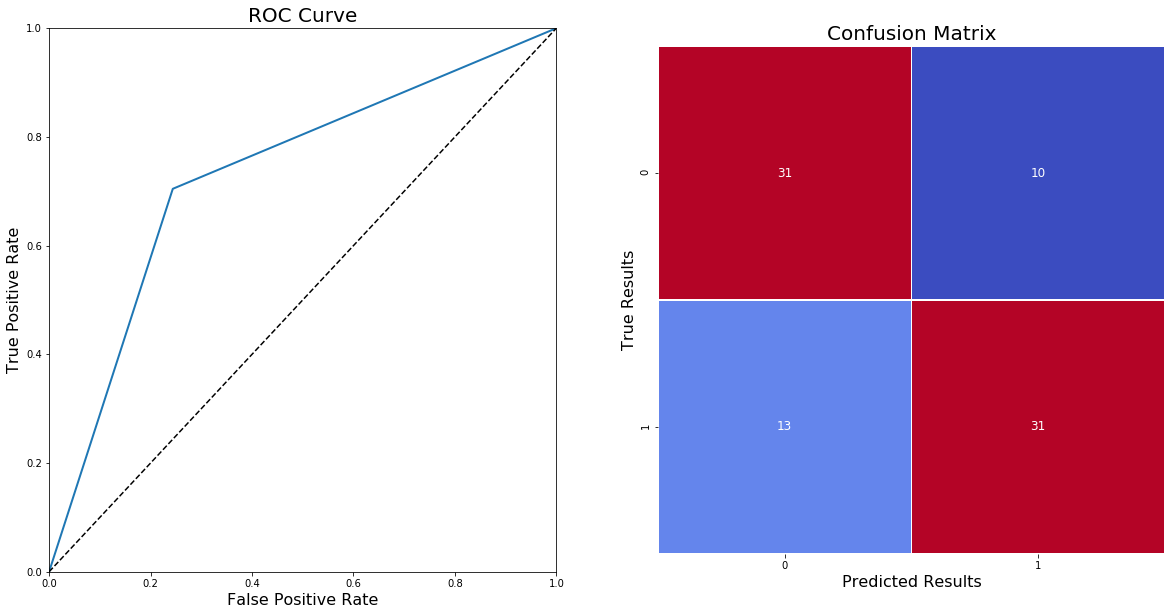

In [39]:
#Plot and Print Accuracy Results (ROC):

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
fig.subplots_adjust(hspace =.2, wspace=.2)

fpr, tpr, thresholds_forest = roc_curve(y_test.values,pred)

print('Random Forest Model: {}%'.format(round(roc_auc_score(y_test, pred)*100,2)))

_= ax[0].plot(fpr, tpr, linewidth=2)
_= ax[0].plot([0, 1], [0, 1], 'k--')

_= ax[0].set_xlim(0,1)
_= ax[0].set_ylim(0,1)

_= ax[0].set_xlabel('False Positive Rate', fontsize=16)
_= ax[0].set_ylabel('True Positive Rate', fontsize=16)
_= ax[0].set_title('ROC Curve', fontsize=20)

#Plot Confusion Matrix:

sns.heatmap(confusion_matrix(y_test, pred),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
            cmap='coolwarm', annot_kws={'size': 12}, fmt='g', ax=ax[1])

_= ax[1].set_xticks([0.5,1.5])
_= ax[1].set_yticks([0.5,1.5])

_= ax[1].set_ylabel('True Results', fontsize=16)
_= ax[1].set_xlabel('Predicted Results', fontsize=16)

_= ax[1].set_title('Confusion Matrix', fontsize=20)

In [40]:
#Save Model Results:

model ={}

model['AdaBoost'] = [round(roc_auc_score(y_test, pred)*100,2), ada_model]

### Model Approach new: Bagging Classifier
<br>
Using RandomizedSearchGrid approach for Hyperparameter Tunning
***

In [41]:
#List Models to be Used:

bagging_clf = BaggingClassifier()

In [42]:
bagging_clf.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [43]:
#Selected Parameters Search Grid:

n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
max_samples = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
max_features = [1, 2, 3, 4, 5, 6, 7]


In [44]:
#Random Grid Creation for Selection:

random_grid = {'n_estimators': n_estimators,
               'max_samples': max_samples,
               'max_features': max_features
               }

In [45]:
#Set GridSearch Using RandomizedSearchCV:

bagging_random = RandomizedSearchCV(estimator=bagging_clf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

In [46]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

bagging_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 235 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:   18.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.9s finished


Executed in: 0 days 00:00:19.525221


In [47]:
#Inspect Best Parameters:

bagging_random.best_params_

{'n_estimators': 90, 'max_samples': 0.3, 'max_features': 7}

In [48]:
#Use Best Estimators for Model:

print(bagging_random.best_estimator_)

bagging_model = bagging_random.best_estimator_

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=7, max_samples=0.3,
         n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)


In [49]:
#Create Predictions based upon RandomForest Model:

pred = bagging_model.predict(X_test)

Random Forest Model: 69.46%


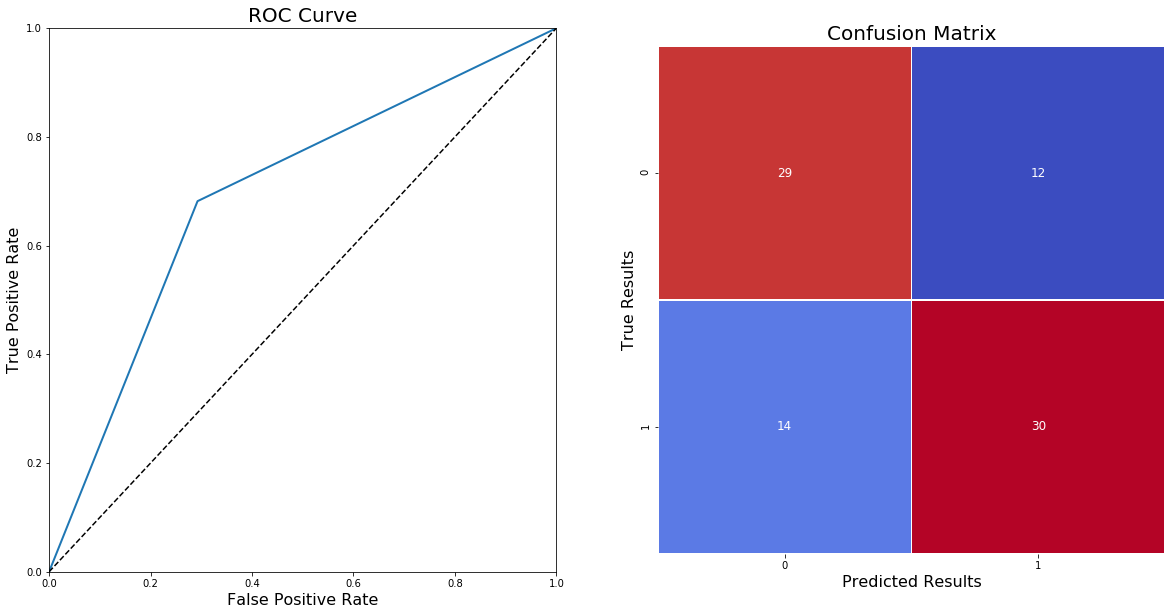

In [50]:
#Plot and Print Accuracy Results (ROC):

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
fig.subplots_adjust(hspace =.2, wspace=.2)

fpr, tpr, thresholds_forest = roc_curve(y_test.values,pred)

print('Random Forest Model: {}%'.format(round(roc_auc_score(y_test, pred)*100,2)))

_= ax[0].plot(fpr, tpr, linewidth=2)
_= ax[0].plot([0, 1], [0, 1], 'k--')

_= ax[0].set_xlim(0,1)
_= ax[0].set_ylim(0,1)

_= ax[0].set_xlabel('False Positive Rate', fontsize=16)
_= ax[0].set_ylabel('True Positive Rate', fontsize=16)
_= ax[0].set_title('ROC Curve', fontsize=20)

#Plot Confusion Matrix:

sns.heatmap(confusion_matrix(y_test, pred),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
            cmap='coolwarm', annot_kws={'size': 12}, fmt='g', ax=ax[1])

_= ax[1].set_xticks([0.5,1.5])
_= ax[1].set_yticks([0.5,1.5])

_= ax[1].set_ylabel('True Results', fontsize=16)
_= ax[1].set_xlabel('Predicted Results', fontsize=16)

_= ax[1].set_title('Confusion Matrix', fontsize=20)

In [51]:
#Save Model Results:

model['Bagging Classifier'] = [round(roc_auc_score(y_test, pred)*100,2), bagging_model]

### Model Approach I: Random Forest
<br>
Using RandomizedSearchGrid approach for Hyperparameter Tunning
***

In [52]:
#List Models to be Used:

forest_clf = RandomForestClassifier()

In [53]:
#Get Default Parameters for Model:

forest_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [54]:
#Selected Parameters Search Grid:

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini','entropy']

In [55]:
#Random Grid Creation for Selection:

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':criterion}

In [56]:
#Set GridSearch Using RandomizedSearchCV:

rf_random = RandomizedSearchCV(estimator=forest_clf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

In [57]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

rf_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.2min finished


Executed in: 0 days 00:06:12.096320


In [58]:
#Inspect Best Parameters:

rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 20,
 'criterion': 'gini',
 'bootstrap': False}

In [59]:
#Use Best Estimators for Model:

print(rf_random.best_estimator_)

rf_model = rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [60]:
#Create Predictions based upon RandomForest Model:

pred = rf_model.predict(X_test)

Random Forest Model: 76.52%


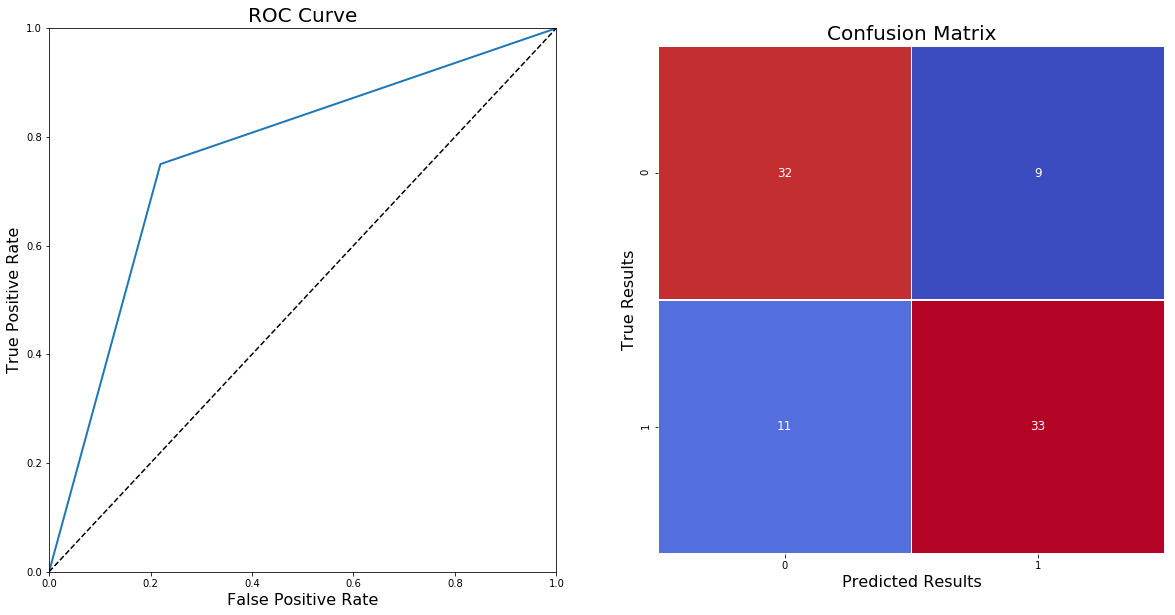

In [61]:
#Plot and Print Accuracy Results (ROC):

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
fig.subplots_adjust(hspace =.2, wspace=.2)

fpr, tpr, thresholds_forest = roc_curve(y_test.values,pred)

print('Random Forest Model: {}%'.format(round(roc_auc_score(y_test, pred)*100,2)))

_= ax[0].plot(fpr, tpr, linewidth=2)
_= ax[0].plot([0, 1], [0, 1], 'k--')

_= ax[0].set_xlim(0,1)
_= ax[0].set_ylim(0,1)

_= ax[0].set_xlabel('False Positive Rate', fontsize=16)
_= ax[0].set_ylabel('True Positive Rate', fontsize=16)
_= ax[0].set_title('ROC Curve', fontsize=20)

#Plot Confusion Matrix:

sns.heatmap(confusion_matrix(y_test, pred),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
            cmap='coolwarm', annot_kws={'size': 12}, fmt='g', ax=ax[1])

_= ax[1].set_xticks([0.5,1.5])
_= ax[1].set_yticks([0.5,1.5])

_= ax[1].set_ylabel('True Results', fontsize=16)
_= ax[1].set_xlabel('Predicted Results', fontsize=16)

_= ax[1].set_title('Confusion Matrix', fontsize=20)

In [62]:
#Save Model Results:

model['Random Forest'] = [round(roc_auc_score(y_test, pred)*100,2), rf_model]

### Model Approach II: GradientBoosting Classifier
<br>
Using RandomizedSearchGrid approach for Hyperparameter Tunning
***

In [63]:
#List Models to be Used:

GBC_classifier = GradientBoostingClassifier()

In [64]:
#Get Default Parameters for Model:

GBC_classifier.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [65]:
#Selected Parameters Search Grid:

n_estimators = [500, 1000, 1500, 2000, 2500]
learning_rate = [0.01, 0.03, 0.05, 0.07, 0.09]
min_samples_split = [2,4,6,8,10]
min_samples_leaf = [3,5,7,9,11]

In [66]:
#Random Grid Creation for Selection:

random_grid = {'n_estimators':n_estimators, 
              'learning_rate':learning_rate,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

In [67]:
#Set GridSearch Using RandomizedSearchCV:

GBC_random = RandomizedSearchCV(estimator=GBC_classifier,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

In [68]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

GBC_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.3min finished


Executed in: 0 days 00:03:18.978412


In [69]:
#Inspect Best Parameters:

GBC_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 8,
 'min_samples_leaf': 9,
 'learning_rate': 0.03}

In [70]:
#Use Best Estimators for Model:

print(GBC_random.best_estimator_)

GBC_model = GBC_random.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=9, min_samples_split=8,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [71]:
#Create Predictions based upon GradientBoosting Model:

pred = GBC_model.predict(X_test)

GradientBoosting Model: 74.0%


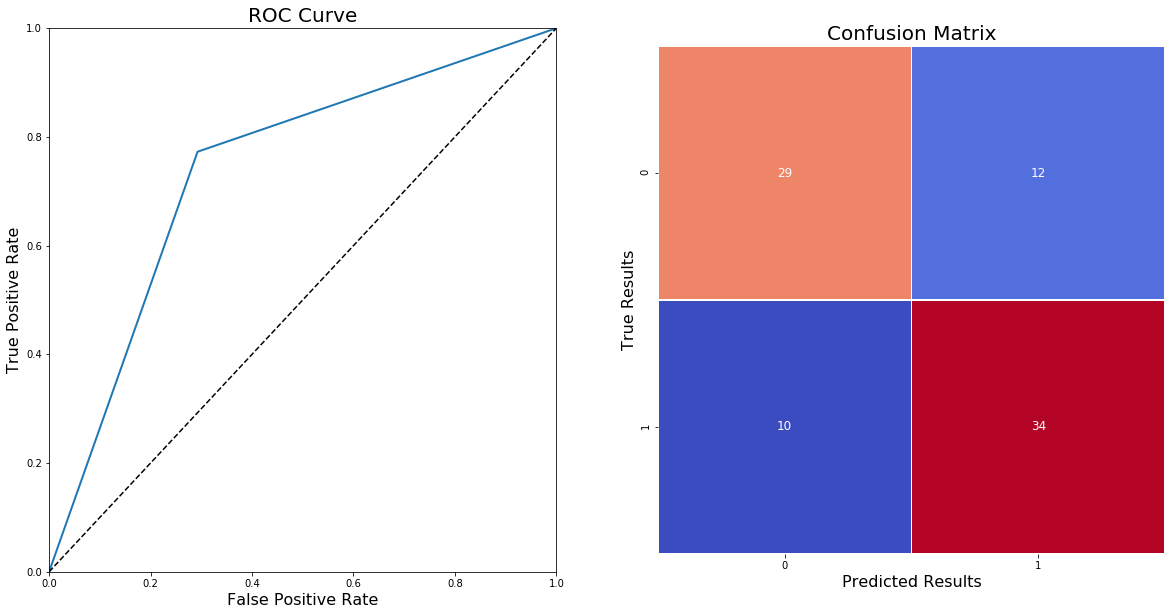

In [72]:
#Plot and Print Accuracy Results (ROC):

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
fig.subplots_adjust(hspace =.2, wspace=.2)

fpr, tpr, thresholds_forest = roc_curve(y_test.values,pred)

print('GradientBoosting Model: {}%'.format(round(roc_auc_score(y_test, pred)*100,2)))

_= ax[0].plot(fpr, tpr, linewidth=2)
_= ax[0].plot([0, 1], [0, 1], 'k--')

_= ax[0].set_xlim(0,1)
_= ax[0].set_ylim(0,1)

_= ax[0].set_xlabel('False Positive Rate', fontsize=16)
_= ax[0].set_ylabel('True Positive Rate', fontsize=16)
_= ax[0].set_title('ROC Curve', fontsize=20)

#Plot Confusion Matrix:

sns.heatmap(confusion_matrix(y_test, pred),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
            cmap='coolwarm', annot_kws={'size': 12}, fmt='g', ax=ax[1])

_= ax[1].set_xticks([0.5,1.5])
_= ax[1].set_yticks([0.5,1.5])

_= ax[1].set_ylabel('True Results', fontsize=16)
_= ax[1].set_xlabel('Predicted Results', fontsize=16)

_= ax[1].set_title('Confusion Matrix', fontsize=20)

In [73]:
#Save Model Results:

model['GradientBoosting'] = [round(roc_auc_score(y_test, pred)*100,2), GBC_model]

### Model Approach III: xgboost Classifier
<br>
Using RandomizedSearchGrid approach for Hyperparameter Tunning
***

In [74]:
#List Models to be Used:

xgb = XGBClassifier(objective='binary:logistic',silent=True, nthread=1)

In [75]:
#Get Default Parameters for Model:

xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': 1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [76]:
#Selected Parameters Search Grid:

learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05]
n_estimators = [100, 300, 600, 900, 1000]
min_child_weight = [1, 5, 10]
gamma = [0.5, 1, 1.5, 2, 5]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.3, 0.5, 0.7, 0.8]
max_depth = [3, 4, 5]

In [77]:
#Random Grid Creation for Selection:

random_grid = {'learning_rate' : learning_rate,
               'n_estimators' : n_estimators,
               'min_child_weight': min_child_weight,
               'gamma': gamma ,
               'subsample': subsample ,
               'colsample_bytree': colsample_bytree,
               'max_depth': max_depth
               }

In [78]:
#Set GridSearch Using RandomizedSearchCV:

xgb_random = RandomizedSearchCV(estimator=xgb,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

In [79]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

xgb_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Executed in: 0 days 00:01:44.878882


In [80]:
#Inspect Best Parameters:

xgb_random.best_params_

{'subsample': 0.9,
 'n_estimators': 300,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.01,
 'gamma': 1,
 'colsample_bytree': 0.3}

In [81]:
#Use Best Estimators for Model:

print(xgb_random.best_estimator_)

xgb_model = xgb_random.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=1, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)


In [82]:
#Create Predictions based upon xgb Model:

pred = xgb_model.predict(X_test)

xgb Model: 70.51%


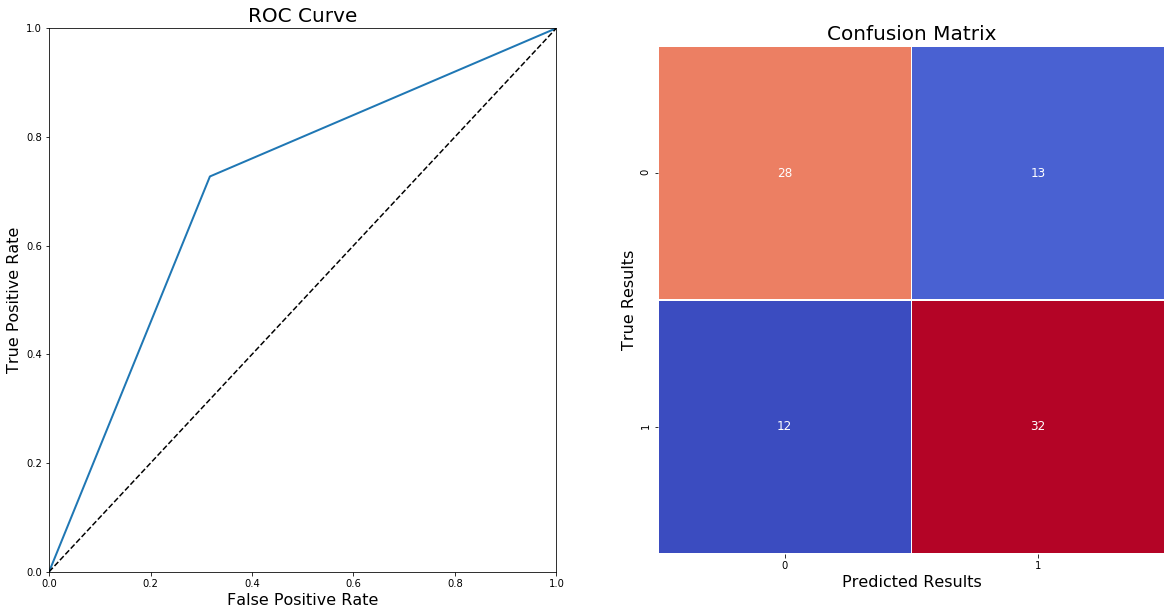

In [83]:
#Plot and Print Accuracy Results (ROC):

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
fig.subplots_adjust(hspace =.2, wspace=.2)

fpr, tpr, thresholds_forest = roc_curve(y_test.values,pred)

print('xgb Model: {}%'.format(round(roc_auc_score(y_test, pred)*100,2)))

_= ax[0].plot(fpr, tpr, linewidth=2)
_= ax[0].plot([0, 1], [0, 1], 'k--')

_= ax[0].set_xlim(0,1)
_= ax[0].set_ylim(0,1)

_= ax[0].set_xlabel('False Positive Rate', fontsize=16)
_= ax[0].set_ylabel('True Positive Rate', fontsize=16)
_= ax[0].set_title('ROC Curve', fontsize=20)

#Plot Confusion Matrix:

sns.heatmap(confusion_matrix(y_test, pred),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
            cmap='coolwarm', annot_kws={'size': 12}, fmt='g', ax=ax[1])

_= ax[1].set_xticks([0.5,1.5])
_= ax[1].set_yticks([0.5,1.5])

_= ax[1].set_ylabel('True Results', fontsize=16)
_= ax[1].set_xlabel('Predicted Results', fontsize=16)

_= ax[1].set_title('Confusion Matrix', fontsize=20)

In [84]:
model['xgb'] = [round(roc_auc_score(y_test, pred)*100,2), xgb_model]

## Model Results Analysis and Predict on Non Classified Data:
***

### Model Result Analysis:
***

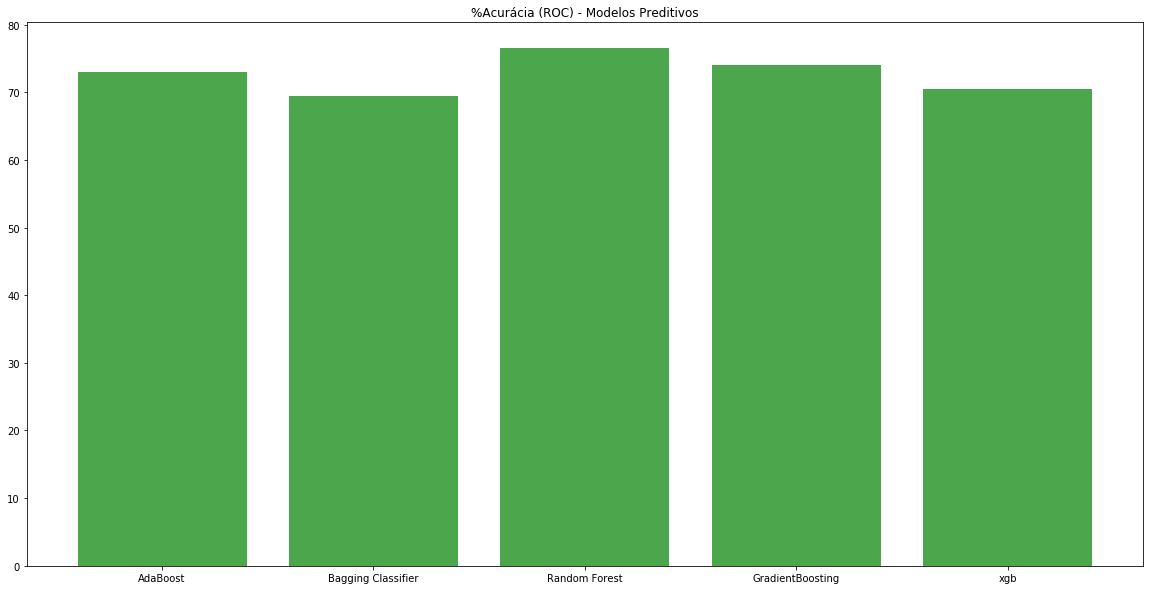

In [85]:
#Plot Main Results from Models:

results = [value[0] for (key, value) in model.items()]
names = [key for (key, value) in model.items()]

_= plt.figure(figsize=(20,10))

_= plt.bar([key for (key, value) in model.items()],[value[0] for (key, value) in model.items()], color='green', alpha=0.7)

_= plt.title('%Acurácia (ROC) - Modelos Preditivos')

In [86]:
#Save Best Model:

pred_model_best = model['Random Forest'][1]

joblib.dump(pred_model_best, 'pred_model_best.model') 

['pred_model_best.model']

### Apply Model on Non Classified Data:
***

In [87]:
#Load .parquet file:

df_predict = pd.read_parquet('predict_dataset.parquet')

In [88]:
df_predict.sample(5)

,LATITUDE_GRAU,LATITUDE_MINUTO,LATITUDE_SEGUNDO,LONGITUDE_GRAU,LONGITUDE_MINUTO,LONGITUDE_SEGUNDO,NORTE_DO_EQUADOR,SUL_DO_EQUADOR,CENTRO-OESTE,NORDESTE,...,VERMICULITA,XISTO,ALTURA_ATUAL_(M),VOLUME_ATUAL_(M3),ALTEAMENTO_A_JUSANTE,ALTEAMENTO_A_MONTANTE_OU_DESCONHECIDO,ALTEAMENTO_POR_LINHA_DE_CENTRO,ETAPA_ÚNICA,INDEFINIDO,TARGET
508,-20.0,22,45.940,-43,55,0.850,0,1,0,0,...,0,0,7.0,7063.00,0,0,0,1,0,0
603,-20.0,12,54.424,-43,26,54.551,0,1,0,0,...,0,0,12.0,7000.00,0,0,0,1,0,0
600,-19.0,57,34.010,-43,35,14.011,0,1,0,0,...,0,0,8.0,7185.66,0,0,0,1,0,0
559,-20.0,8,21.900,-44,24,2.300,0,1,0,0,...,0,0,3.0,200.00,0,0,0,1,0,0
647,-16.0,14,28.910,-56,36,17.520,0,1,1,0,...,0,0,2.0,590000.00,1,0,0,0,0,0


In [89]:
#Drop Target Column:

df_predict.drop(labels=['TARGET'], axis=1, inplace=True)

In [90]:
#Apply Scaling on Base:

base_pred = scale_var(df_predict,['LATITUDE_GRAU', 'LATITUDE_MINUTO', 'LATITUDE_SEGUNDO',
                 'LONGITUDE_GRAU', 'LONGITUDE_MINUTO', 'LONGITUDE_SEGUNDO',
                 'ALTURA_ATUAL_(M)', 'VOLUME_ATUAL_(M3)'])

In [91]:
#Predict Values using Best Model:

pred = pred_model_best.predict(base_pred)

df_predict['TARGET'] = pred

In [92]:
df_predict.sample(5)

,LATITUDE_GRAU,LATITUDE_MINUTO,LATITUDE_SEGUNDO,LONGITUDE_GRAU,LONGITUDE_MINUTO,LONGITUDE_SEGUNDO,NORTE_DO_EQUADOR,SUL_DO_EQUADOR,CENTRO-OESTE,NORDESTE,...,VERMICULITA,XISTO,ALTURA_ATUAL_(M),VOLUME_ATUAL_(M3),ALTEAMENTO_A_JUSANTE,ALTEAMENTO_A_MONTANTE_OU_DESCONHECIDO,ALTEAMENTO_POR_LINHA_DE_CENTRO,ETAPA_ÚNICA,INDEFINIDO,TARGET
744,-1.045240,0.701669,0.703655,0.125063,0.547789,1.366445,0,1,0,0,...,0,0,-0.456740,0.967219,0,0,0,1,0,1
428,2.390678,0.936303,-0.364301,-2.008818,-1.128651,1.082682,0,1,0,0,...,0,0,-0.482089,-0.018781,0,0,0,1,0,0
589,-0.597077,-1.175407,0.323535,0.617497,-0.709541,1.644532,0,1,0,0,...,0,0,-0.456740,-0.496214,0,0,0,1,0,0
655,0.299250,1.405573,-1.727905,-1.352239,0.248425,-0.211275,0,1,1,0,...,0,0,-1.470698,-0.500621,0,0,0,0,1,0
507,-0.597077,-0.295528,0.430331,0.781641,1.445882,0.939666,0,1,0,0,...,0,0,-0.710230,-0.490916,0,0,0,1,0,0


In [93]:
#Store All Results:

all_results = pd.concat([df_model,df_predict], axis=0)
all_results.to_excel('all_results.xlsx')

In [94]:
#Load Base Table to compose Results:

df_original = pd.read_excel('datasets/00_Dataset_base.xls', sheet_name='Dataset_Base')

In [95]:
#Merge Results into Base Table:

df_final_results = pd.merge(df_original,all_results, left_on=df_original.index, right_on=all_results.index, how='left')

df_final_results.sample(5)

,key_0,NOME DA BARRAGEM DE MINERAÇÃO,NOME DO EMPREENDEDOR,CPF/CNPJ,LATITUDE,LONGITUDE,POSICIONAMENTO,UF,MUNICÍPIO,MINÉRIO PRINCIPAL,...,VERMICULITA,XISTO,ALTURA_ATUAL_(M),VOLUME_ATUAL_(M3),ALTEAMENTO_A_JUSANTE,ALTEAMENTO_A_MONTANTE_OU_DESCONHECIDO,ALTEAMENTO_POR_LINHA_DE_CENTRO,ETAPA_ÚNICA,INDEFINIDO,TARGET
49,49,B1 - AGUA PRETA,Companhia Siderúrgica Nacional,33.042.730/0001-04,"-20°37'39.860""","-43°45'47.180""",Sul do Equador,MG,CONSELHEIRO LAFAIETE,Minério de Manganês,...,0.0,0.0,17.000000,1.000000e+05,0.0,0.0,0.0,1.0,0.0,1.0
436,436,Barragem do Muriacá,Cadam S.a.,04.788.980/0001-90,"-0°53'37.200""","-52°21'50.700""",Sul do Equador,AP,VITÓRIA DO JARI,Caulim,...,0.0,0.0,0.810708,-3.093297e-01,0.0,0.0,0.0,1.0,0.0,0.0
526,526,BARRAGEM USINA BENEFICIAMENTO ESPONGILITO - IVA,Magnesita Mineração S.A. Filial: FAZENDA BELA ...,00.592.603/0023-35,"-19°24'38.340""","-47°57'20.460""",Sul do Equador,MG,UBERABA,Argila,...,0.0,0.0,-1.217209,-4.848092e-01,0.0,0.0,0.0,1.0,0.0,0.0
652,652,OURINHOS I,João Ginenes Rodrigues,00.051.095/7858-34,"-16°07'11.800""","-56°35'15.800""",Sul do Equador,MT,POCONÉ,Argila,...,0.0,0.0,2.052807,4.281831e+00,1.0,0.0,0.0,0.0,0.0,1.0
146,146,Campo Grande,Vale S A Filial: Vale Mariana,33.592.510/0412-68,"-20°10'33.845""","-43°29'14.340""",Sul do Equador,MG,MARIANA,Minério de Ferro,...,0.0,0.0,99.300000,2.297889e+07,0.0,0.0,1.0,0.0,0.0,1.0


In [96]:
#Store Final Results (All Data - Classified and Predicted) on Excel File:

df_final_results.to_excel('datasets/01_Dataset_Previsao.xls')